# Demo: Building Variational Autoencoders in Pytorch

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/VAE_mnist.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Variational Autoencoder with Pytorch, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
!pip list | grep torch

torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = '../dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [6]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, latent_dims):
        
        super(VariationalEncoder, self).__init__()
        
        # Create all layers
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        
        # self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z

In [7]:
### Traditional decoder
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss
*Note that "d" is the size of a latent space*

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [13]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [14]:
### Testing function
def test_epoch(vae, device, dataloader):
    
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            
            # Move tensor to the proper device
            x = x.to(device)
            
            # Encode data
            encoded_data = vae.encoder(x)
            
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [15]:
def plot_ae_outputs(encoder,decoder,n=5):
    
    plt.figure(figsize=(10,4.5))
    
    for i in range(n):
        
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

        if i == n//2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.show()   

	 partial train loss (single batch): 69249.851562
	 partial train loss (single batch): 67758.789062
	 partial train loss (single batch): 66179.000000
	 partial train loss (single batch): 64701.082031
	 partial train loss (single batch): 63575.117188
	 partial train loss (single batch): 62212.160156
	 partial train loss (single batch): 61301.613281
	 partial train loss (single batch): 60601.148438
	 partial train loss (single batch): 59768.726562
	 partial train loss (single batch): 59242.140625
	 partial train loss (single batch): 58764.007812
	 partial train loss (single batch): 58259.656250
	 partial train loss (single batch): 57519.968750
	 partial train loss (single batch): 57283.265625
	 partial train loss (single batch): 56818.296875
	 partial train loss (single batch): 56310.082031
	 partial train loss (single batch): 55991.007812
	 partial train loss (single batch): 55491.406250
	 partial train loss (single batch): 54940.660156
	 partial train loss (single batch): 54602.406250


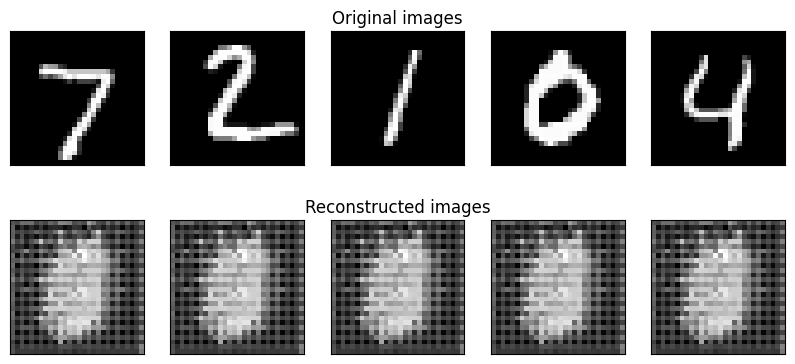

	 partial train loss (single batch): 20180.822266
	 partial train loss (single batch): 19949.906250
	 partial train loss (single batch): 19867.140625
	 partial train loss (single batch): 19884.826172
	 partial train loss (single batch): 19683.658203
	 partial train loss (single batch): 19726.246094
	 partial train loss (single batch): 19618.558594
	 partial train loss (single batch): 19469.175781
	 partial train loss (single batch): 19596.255859
	 partial train loss (single batch): 19312.025391
	 partial train loss (single batch): 19296.812500
	 partial train loss (single batch): 19205.347656
	 partial train loss (single batch): 19417.148438
	 partial train loss (single batch): 19187.369141
	 partial train loss (single batch): 19047.488281
	 partial train loss (single batch): 19184.941406
	 partial train loss (single batch): 19010.328125
	 partial train loss (single batch): 18954.417969
	 partial train loss (single batch): 18905.414062
	 partial train loss (single batch): 18986.208984


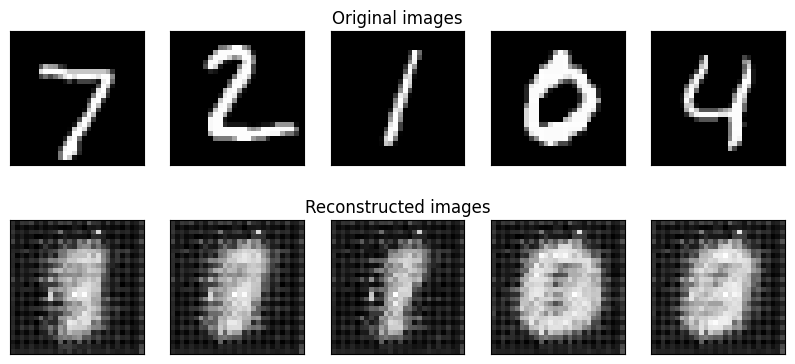

	 partial train loss (single batch): 14676.569336
	 partial train loss (single batch): 14425.213867
	 partial train loss (single batch): 14456.101562
	 partial train loss (single batch): 14358.889648
	 partial train loss (single batch): 14162.675781
	 partial train loss (single batch): 14384.452148
	 partial train loss (single batch): 14232.232422
	 partial train loss (single batch): 14216.456055
	 partial train loss (single batch): 14242.660156
	 partial train loss (single batch): 14168.615234
	 partial train loss (single batch): 14073.465820
	 partial train loss (single batch): 14082.320312
	 partial train loss (single batch): 14346.673828
	 partial train loss (single batch): 14068.867188
	 partial train loss (single batch): 14049.417969
	 partial train loss (single batch): 14266.207031
	 partial train loss (single batch): 14000.395508
	 partial train loss (single batch): 14052.504883
	 partial train loss (single batch): 13949.147461
	 partial train loss (single batch): 14172.263672


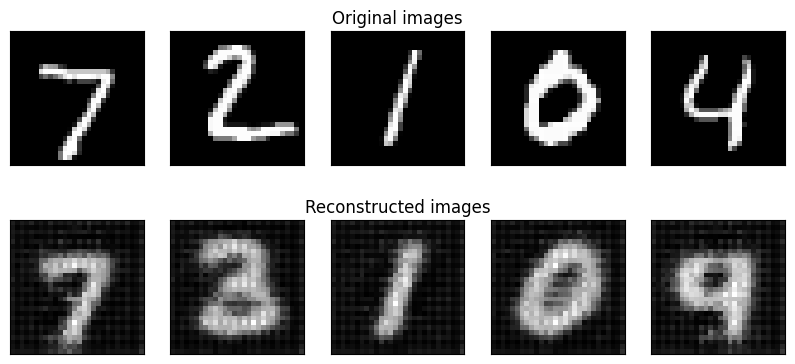

	 partial train loss (single batch): 11939.047852
	 partial train loss (single batch): 11596.642578
	 partial train loss (single batch): 11748.575195
	 partial train loss (single batch): 11666.625000
	 partial train loss (single batch): 11419.386719
	 partial train loss (single batch): 11729.103516
	 partial train loss (single batch): 11519.061523
	 partial train loss (single batch): 11501.930664
	 partial train loss (single batch): 11521.527344
	 partial train loss (single batch): 11505.923828
	 partial train loss (single batch): 11427.208008
	 partial train loss (single batch): 11605.670898
	 partial train loss (single batch): 11739.515625
	 partial train loss (single batch): 11570.142578
	 partial train loss (single batch): 11354.667969
	 partial train loss (single batch): 11712.973633
	 partial train loss (single batch): 11386.941406
	 partial train loss (single batch): 11572.772461
	 partial train loss (single batch): 11604.389648
	 partial train loss (single batch): 11729.621094


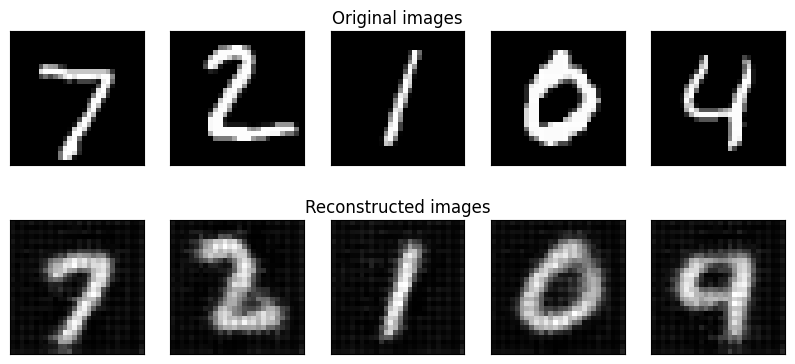

	 partial train loss (single batch): 10477.160156
	 partial train loss (single batch): 10170.688477
	 partial train loss (single batch): 10232.381836
	 partial train loss (single batch): 9998.395508
	 partial train loss (single batch): 9844.723633
	 partial train loss (single batch): 10241.166016
	 partial train loss (single batch): 9972.358398
	 partial train loss (single batch): 9975.570312
	 partial train loss (single batch): 10081.375000
	 partial train loss (single batch): 10077.619141
	 partial train loss (single batch): 9918.648438
	 partial train loss (single batch): 10198.951172
	 partial train loss (single batch): 10245.900391
	 partial train loss (single batch): 9957.957031
	 partial train loss (single batch): 9790.012695
	 partial train loss (single batch): 10176.192383
	 partial train loss (single batch): 9996.732422
	 partial train loss (single batch): 10073.531250
	 partial train loss (single batch): 10091.322266
	 partial train loss (single batch): 10161.029297
	 partia

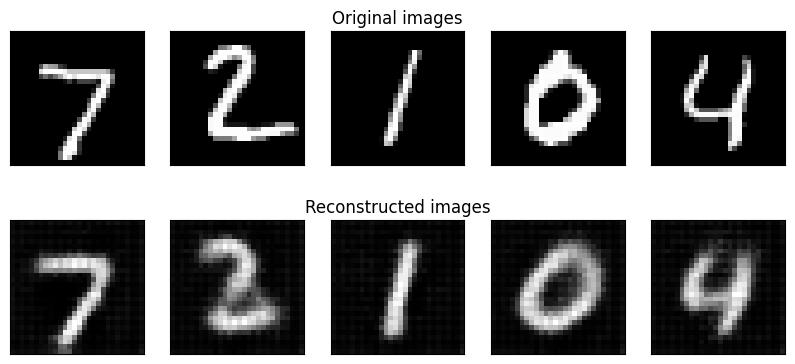

	 partial train loss (single batch): 9886.673828
	 partial train loss (single batch): 9532.830078
	 partial train loss (single batch): 9656.384766
	 partial train loss (single batch): 9413.472656
	 partial train loss (single batch): 9298.183594
	 partial train loss (single batch): 9663.068359
	 partial train loss (single batch): 9507.687500
	 partial train loss (single batch): 9426.444336
	 partial train loss (single batch): 9548.260742
	 partial train loss (single batch): 9564.997070
	 partial train loss (single batch): 9368.816406
	 partial train loss (single batch): 9639.168945
	 partial train loss (single batch): 9784.621094
	 partial train loss (single batch): 9402.958984
	 partial train loss (single batch): 9306.579102
	 partial train loss (single batch): 9599.899414
	 partial train loss (single batch): 9509.083984
	 partial train loss (single batch): 9531.820312
	 partial train loss (single batch): 9571.683594
	 partial train loss (single batch): 9700.093750
	 partial train loss

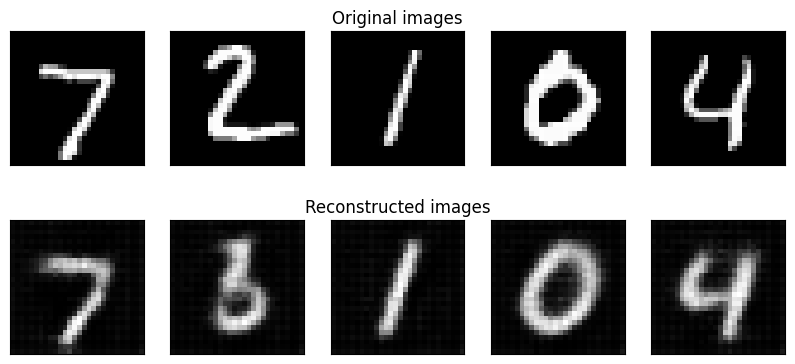

	 partial train loss (single batch): 9689.166016
	 partial train loss (single batch): 9266.808594
	 partial train loss (single batch): 9407.990234
	 partial train loss (single batch): 9197.672852
	 partial train loss (single batch): 9072.717773
	 partial train loss (single batch): 9429.611328
	 partial train loss (single batch): 9199.342773
	 partial train loss (single batch): 9185.008789
	 partial train loss (single batch): 9269.336914
	 partial train loss (single batch): 9299.305664
	 partial train loss (single batch): 9097.902344
	 partial train loss (single batch): 9504.603516
	 partial train loss (single batch): 9463.459961
	 partial train loss (single batch): 9080.164062
	 partial train loss (single batch): 9052.460938
	 partial train loss (single batch): 9410.232422
	 partial train loss (single batch): 9196.998047
	 partial train loss (single batch): 9218.992188
	 partial train loss (single batch): 9257.849609
	 partial train loss (single batch): 9371.081055
	 partial train loss

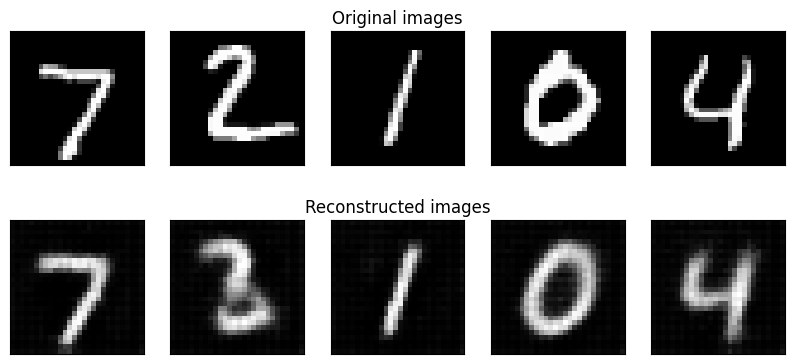

	 partial train loss (single batch): 9362.038086
	 partial train loss (single batch): 9128.123047
	 partial train loss (single batch): 9314.097656
	 partial train loss (single batch): 8908.928711
	 partial train loss (single batch): 8862.611328
	 partial train loss (single batch): 9206.480469
	 partial train loss (single batch): 8907.588867
	 partial train loss (single batch): 9004.367188
	 partial train loss (single batch): 9096.572266
	 partial train loss (single batch): 9150.511719
	 partial train loss (single batch): 8917.417969
	 partial train loss (single batch): 9195.713867
	 partial train loss (single batch): 9408.039062
	 partial train loss (single batch): 8916.960938
	 partial train loss (single batch): 8857.458008
	 partial train loss (single batch): 9113.853516
	 partial train loss (single batch): 9114.110352
	 partial train loss (single batch): 9090.271484
	 partial train loss (single batch): 9157.653320
	 partial train loss (single batch): 9277.300781
	 partial train loss

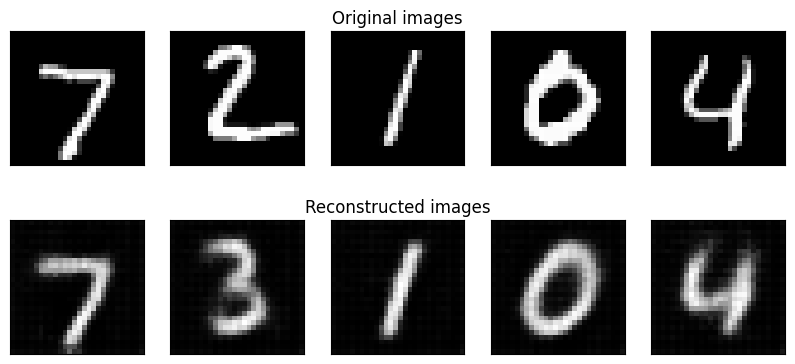

	 partial train loss (single batch): 9342.250977
	 partial train loss (single batch): 9008.896484
	 partial train loss (single batch): 9191.759766
	 partial train loss (single batch): 8855.779297
	 partial train loss (single batch): 8774.345703
	 partial train loss (single batch): 9164.697266
	 partial train loss (single batch): 8878.711914
	 partial train loss (single batch): 8899.577148
	 partial train loss (single batch): 9039.869141
	 partial train loss (single batch): 9051.217773
	 partial train loss (single batch): 8817.353516
	 partial train loss (single batch): 9062.696289
	 partial train loss (single batch): 9192.814453
	 partial train loss (single batch): 8859.791016
	 partial train loss (single batch): 8825.433594
	 partial train loss (single batch): 9003.681641
	 partial train loss (single batch): 9005.619141
	 partial train loss (single batch): 8955.564453
	 partial train loss (single batch): 8969.109375
	 partial train loss (single batch): 9120.972656
	 partial train loss

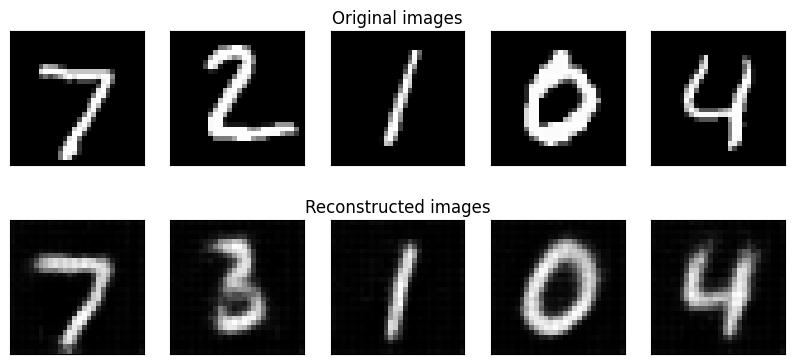

	 partial train loss (single batch): 9243.460938
	 partial train loss (single batch): 8900.246094
	 partial train loss (single batch): 9163.153320
	 partial train loss (single batch): 8738.878906
	 partial train loss (single batch): 8601.179688
	 partial train loss (single batch): 8940.217773
	 partial train loss (single batch): 8708.792969
	 partial train loss (single batch): 8856.431641
	 partial train loss (single batch): 8913.537109
	 partial train loss (single batch): 8925.483398
	 partial train loss (single batch): 8714.476562
	 partial train loss (single batch): 8982.454102
	 partial train loss (single batch): 9245.453125
	 partial train loss (single batch): 8642.996094
	 partial train loss (single batch): 8638.646484
	 partial train loss (single batch): 8886.162109
	 partial train loss (single batch): 8875.648438
	 partial train loss (single batch): 8819.166016
	 partial train loss (single batch): 8883.292969
	 partial train loss (single batch): 9028.761719
	 partial train loss

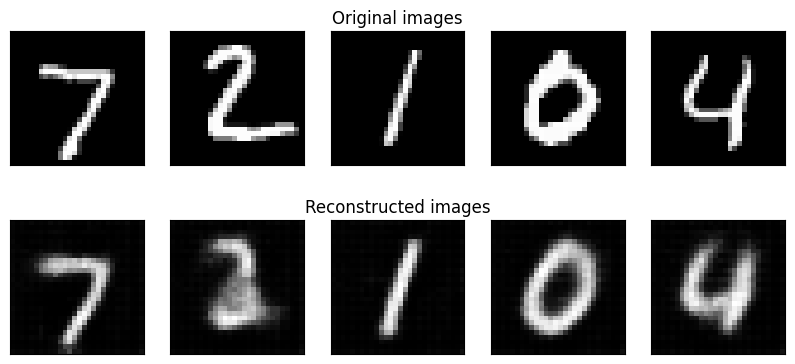

	 partial train loss (single batch): 9061.273438
	 partial train loss (single batch): 8810.886719
	 partial train loss (single batch): 9038.257812
	 partial train loss (single batch): 8691.636719
	 partial train loss (single batch): 8658.123047
	 partial train loss (single batch): 9012.888672
	 partial train loss (single batch): 8682.630859
	 partial train loss (single batch): 8737.483398
	 partial train loss (single batch): 8845.181641
	 partial train loss (single batch): 8887.877930
	 partial train loss (single batch): 8643.955078
	 partial train loss (single batch): 8931.817383
	 partial train loss (single batch): 9079.560547
	 partial train loss (single batch): 8645.578125
	 partial train loss (single batch): 8540.208984
	 partial train loss (single batch): 8755.944336
	 partial train loss (single batch): 8793.310547
	 partial train loss (single batch): 8713.647461
	 partial train loss (single batch): 8720.243164
	 partial train loss (single batch): 9030.895508
	 partial train loss

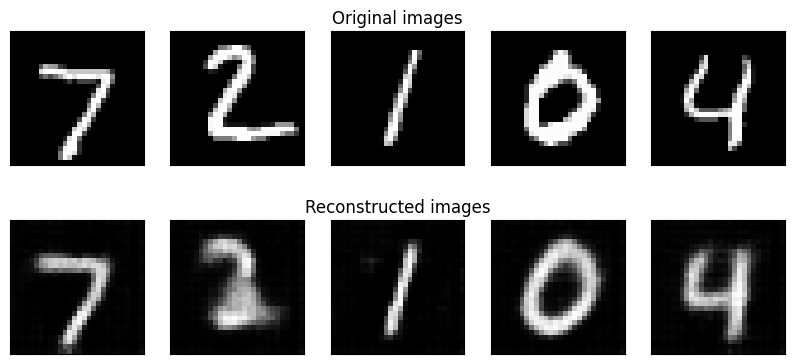

	 partial train loss (single batch): 9164.704102
	 partial train loss (single batch): 8747.507812
	 partial train loss (single batch): 8937.408203
	 partial train loss (single batch): 8643.947266
	 partial train loss (single batch): 8567.489258
	 partial train loss (single batch): 9041.180664
	 partial train loss (single batch): 8641.208984
	 partial train loss (single batch): 8661.456055
	 partial train loss (single batch): 8839.988281
	 partial train loss (single batch): 8855.958984
	 partial train loss (single batch): 8669.369141
	 partial train loss (single batch): 8879.830078
	 partial train loss (single batch): 9014.855469
	 partial train loss (single batch): 8573.385742
	 partial train loss (single batch): 8569.134766
	 partial train loss (single batch): 8760.903320
	 partial train loss (single batch): 8772.935547
	 partial train loss (single batch): 8703.741211
	 partial train loss (single batch): 8784.339844
	 partial train loss (single batch): 8873.449219
	 partial train loss

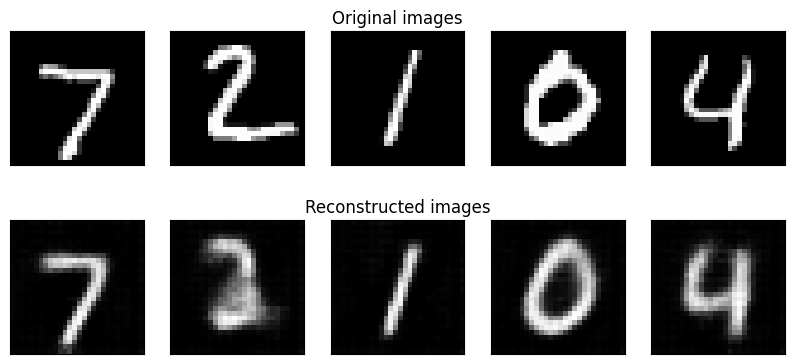

	 partial train loss (single batch): 9023.486328
	 partial train loss (single batch): 8787.210938
	 partial train loss (single batch): 8921.816406
	 partial train loss (single batch): 8574.447266
	 partial train loss (single batch): 8518.181641
	 partial train loss (single batch): 8875.675781
	 partial train loss (single batch): 8582.578125
	 partial train loss (single batch): 8644.409180
	 partial train loss (single batch): 8758.875000
	 partial train loss (single batch): 8788.886719
	 partial train loss (single batch): 8535.991211
	 partial train loss (single batch): 8832.550781
	 partial train loss (single batch): 8972.770508
	 partial train loss (single batch): 8494.902344
	 partial train loss (single batch): 8507.521484
	 partial train loss (single batch): 8682.480469
	 partial train loss (single batch): 8721.861328
	 partial train loss (single batch): 8586.441406
	 partial train loss (single batch): 8691.335938
	 partial train loss (single batch): 8878.203125
	 partial train loss

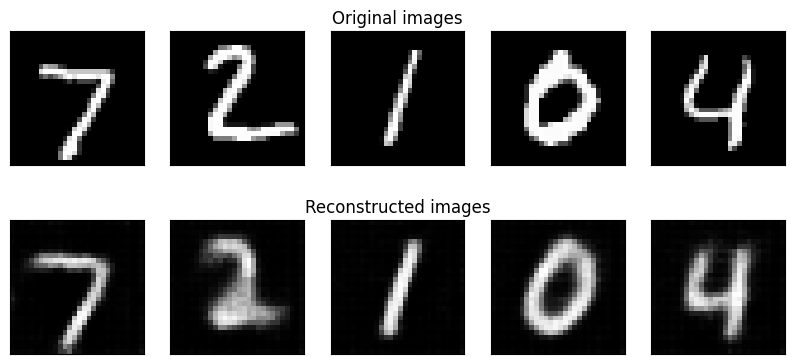

	 partial train loss (single batch): 8941.061523
	 partial train loss (single batch): 8671.116211
	 partial train loss (single batch): 8917.042969
	 partial train loss (single batch): 8560.928711
	 partial train loss (single batch): 8411.431641
	 partial train loss (single batch): 8812.588867
	 partial train loss (single batch): 8498.679688
	 partial train loss (single batch): 8563.082031
	 partial train loss (single batch): 8682.877930
	 partial train loss (single batch): 8716.257812
	 partial train loss (single batch): 8506.818359
	 partial train loss (single batch): 8794.052734
	 partial train loss (single batch): 8930.970703
	 partial train loss (single batch): 8505.304688
	 partial train loss (single batch): 8456.712891
	 partial train loss (single batch): 8627.775391
	 partial train loss (single batch): 8730.066406
	 partial train loss (single batch): 8626.755859
	 partial train loss (single batch): 8643.697266
	 partial train loss (single batch): 8901.794922
	 partial train loss

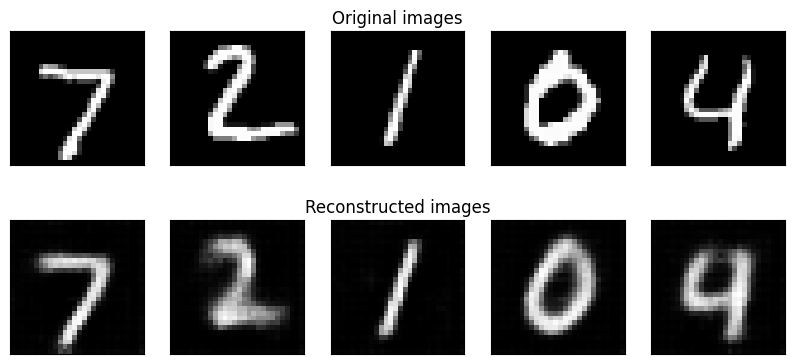

	 partial train loss (single batch): 8966.619141
	 partial train loss (single batch): 8618.369141
	 partial train loss (single batch): 8902.882812
	 partial train loss (single batch): 8485.103516
	 partial train loss (single batch): 8423.656250
	 partial train loss (single batch): 8800.631836
	 partial train loss (single batch): 8542.090820
	 partial train loss (single batch): 8544.012695
	 partial train loss (single batch): 8610.514648
	 partial train loss (single batch): 8743.017578
	 partial train loss (single batch): 8448.153320
	 partial train loss (single batch): 8626.250000
	 partial train loss (single batch): 8927.330078
	 partial train loss (single batch): 8406.960938
	 partial train loss (single batch): 8419.901367
	 partial train loss (single batch): 8568.727539
	 partial train loss (single batch): 8544.062500
	 partial train loss (single batch): 8642.372070
	 partial train loss (single batch): 8597.302734
	 partial train loss (single batch): 8823.691406
	 partial train loss

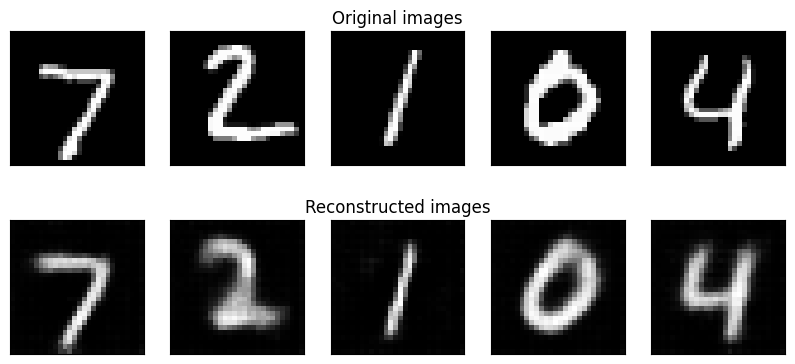

	 partial train loss (single batch): 8902.917969
	 partial train loss (single batch): 8588.820312
	 partial train loss (single batch): 8905.559570
	 partial train loss (single batch): 8522.736328
	 partial train loss (single batch): 8365.450195
	 partial train loss (single batch): 8789.002930
	 partial train loss (single batch): 8527.279297
	 partial train loss (single batch): 8524.588867
	 partial train loss (single batch): 8599.281250
	 partial train loss (single batch): 8773.507812
	 partial train loss (single batch): 8492.724609
	 partial train loss (single batch): 8765.005859
	 partial train loss (single batch): 8929.203125
	 partial train loss (single batch): 8443.316406
	 partial train loss (single batch): 8402.964844
	 partial train loss (single batch): 8469.232422
	 partial train loss (single batch): 8674.050781
	 partial train loss (single batch): 8495.568359
	 partial train loss (single batch): 8578.105469
	 partial train loss (single batch): 8838.242188
	 partial train loss

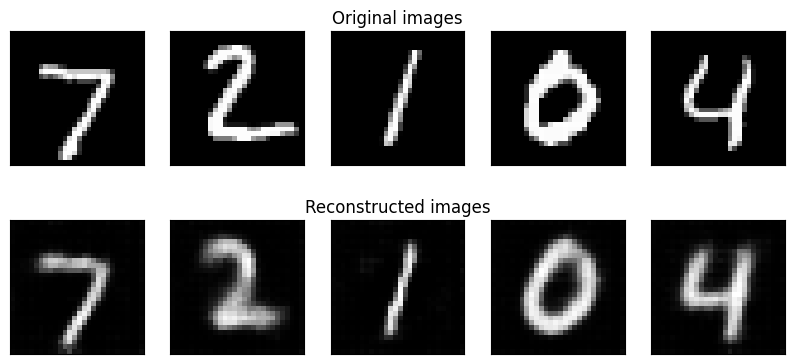

	 partial train loss (single batch): 8907.290039
	 partial train loss (single batch): 8556.692383
	 partial train loss (single batch): 8821.709961
	 partial train loss (single batch): 8429.751953
	 partial train loss (single batch): 8325.511719
	 partial train loss (single batch): 8779.783203
	 partial train loss (single batch): 8448.884766
	 partial train loss (single batch): 8552.061523
	 partial train loss (single batch): 8597.320312
	 partial train loss (single batch): 8602.248047
	 partial train loss (single batch): 8416.838867
	 partial train loss (single batch): 8691.715820
	 partial train loss (single batch): 8898.714844
	 partial train loss (single batch): 8439.564453
	 partial train loss (single batch): 8415.111328
	 partial train loss (single batch): 8528.386719
	 partial train loss (single batch): 8611.599609
	 partial train loss (single batch): 8542.205078
	 partial train loss (single batch): 8523.474609
	 partial train loss (single batch): 8794.259766
	 partial train loss

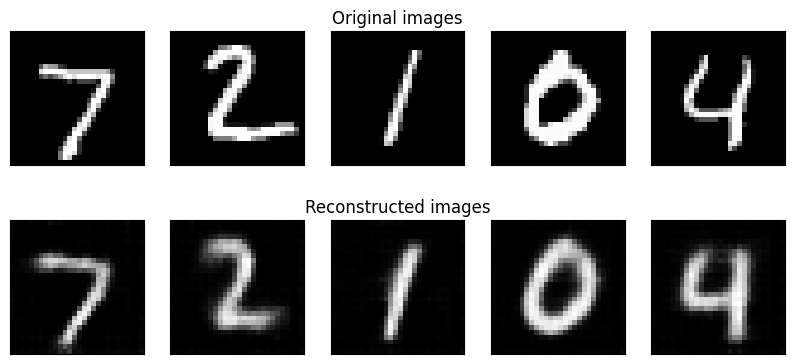

	 partial train loss (single batch): 8991.285156
	 partial train loss (single batch): 8521.931641
	 partial train loss (single batch): 8808.311523
	 partial train loss (single batch): 8405.513672
	 partial train loss (single batch): 8322.110352
	 partial train loss (single batch): 8646.798828
	 partial train loss (single batch): 8442.249023
	 partial train loss (single batch): 8421.988281
	 partial train loss (single batch): 8587.392578
	 partial train loss (single batch): 8618.497070
	 partial train loss (single batch): 8365.925781
	 partial train loss (single batch): 8637.572266
	 partial train loss (single batch): 8784.426758
	 partial train loss (single batch): 8353.055664
	 partial train loss (single batch): 8365.853516
	 partial train loss (single batch): 8454.773438
	 partial train loss (single batch): 8567.585938
	 partial train loss (single batch): 8450.017578
	 partial train loss (single batch): 8542.089844
	 partial train loss (single batch): 8733.689453
	 partial train loss

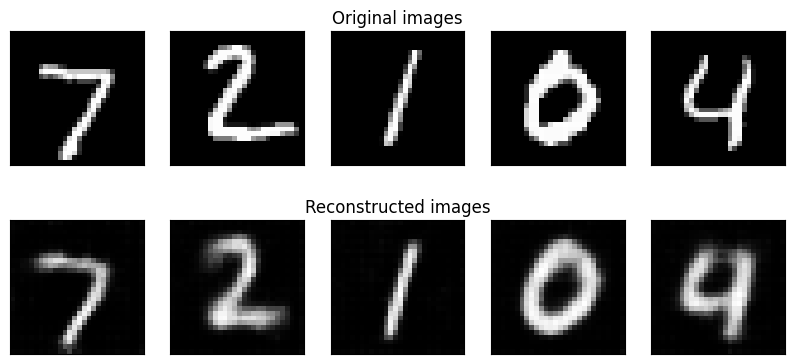

	 partial train loss (single batch): 8804.113281
	 partial train loss (single batch): 8511.626953
	 partial train loss (single batch): 8802.519531
	 partial train loss (single batch): 8389.292969
	 partial train loss (single batch): 8395.148438
	 partial train loss (single batch): 8733.056641
	 partial train loss (single batch): 8447.723633
	 partial train loss (single batch): 8515.988281
	 partial train loss (single batch): 8474.085938
	 partial train loss (single batch): 8663.658203
	 partial train loss (single batch): 8381.248047
	 partial train loss (single batch): 8662.721680
	 partial train loss (single batch): 8886.844727
	 partial train loss (single batch): 8338.114258
	 partial train loss (single batch): 8359.092773
	 partial train loss (single batch): 8505.796875
	 partial train loss (single batch): 8602.008789
	 partial train loss (single batch): 8439.390625
	 partial train loss (single batch): 8524.324219
	 partial train loss (single batch): 8767.427734
	 partial train loss

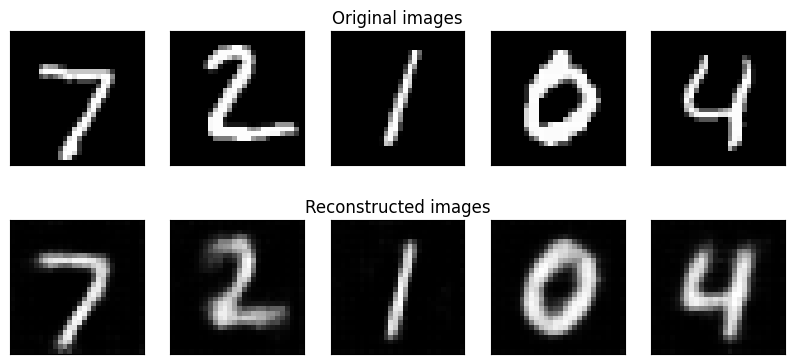

	 partial train loss (single batch): 8847.043945
	 partial train loss (single batch): 8454.781250
	 partial train loss (single batch): 8766.056641
	 partial train loss (single batch): 8403.542969
	 partial train loss (single batch): 8270.268555
	 partial train loss (single batch): 8694.226562
	 partial train loss (single batch): 8393.935547
	 partial train loss (single batch): 8367.542969
	 partial train loss (single batch): 8593.830078
	 partial train loss (single batch): 8631.750000
	 partial train loss (single batch): 8323.644531
	 partial train loss (single batch): 8708.777344
	 partial train loss (single batch): 8785.993164
	 partial train loss (single batch): 8304.771484
	 partial train loss (single batch): 8303.125000
	 partial train loss (single batch): 8473.108398
	 partial train loss (single batch): 8531.714844
	 partial train loss (single batch): 8367.955078
	 partial train loss (single batch): 8485.993164
	 partial train loss (single batch): 8690.029297
	 partial train loss

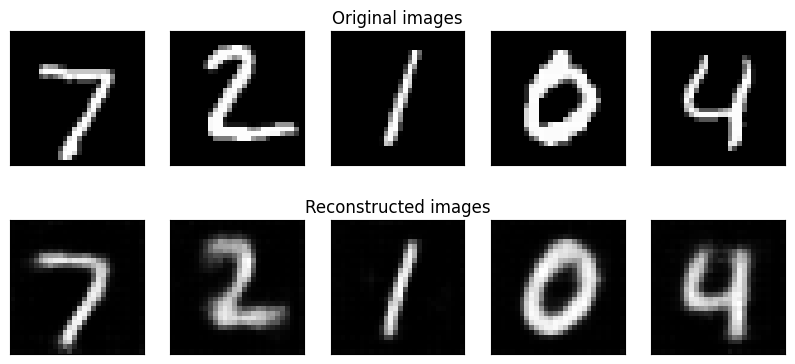

CPU times: user 30.1 s, sys: 198 ms, total: 30.3 s
Wall time: 30.7 s


In [16]:
%%time

num_epochs = 20 # 50
history_vae={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):

    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    history_vae['train_loss'].append(train_loss)
    history_vae['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    plot_ae_outputs(vae.encoder,vae.decoder,n=5)

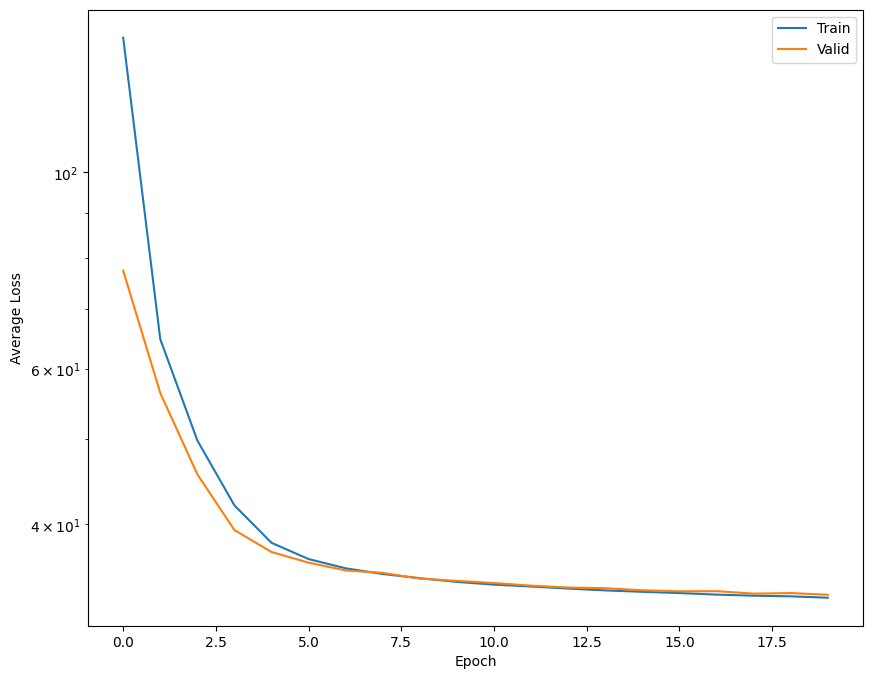

In [17]:
# Plot training performance
test_epoch(vae,device,test_loader)
plt.figure(figsize=(10,8))
plt.semilogy(history_vae['train_loss'], label='Train')
plt.semilogy(history_vae['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4.Visualize latent space

100%|█████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3435.76it/s]


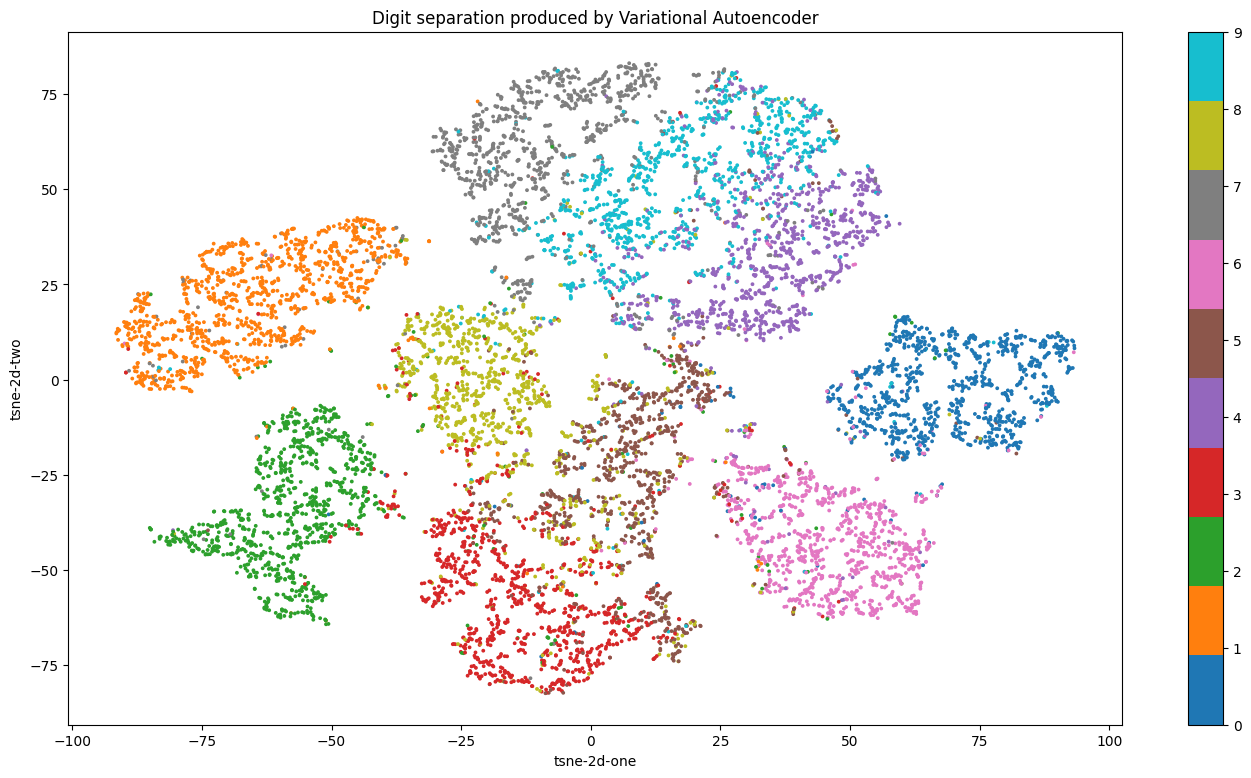

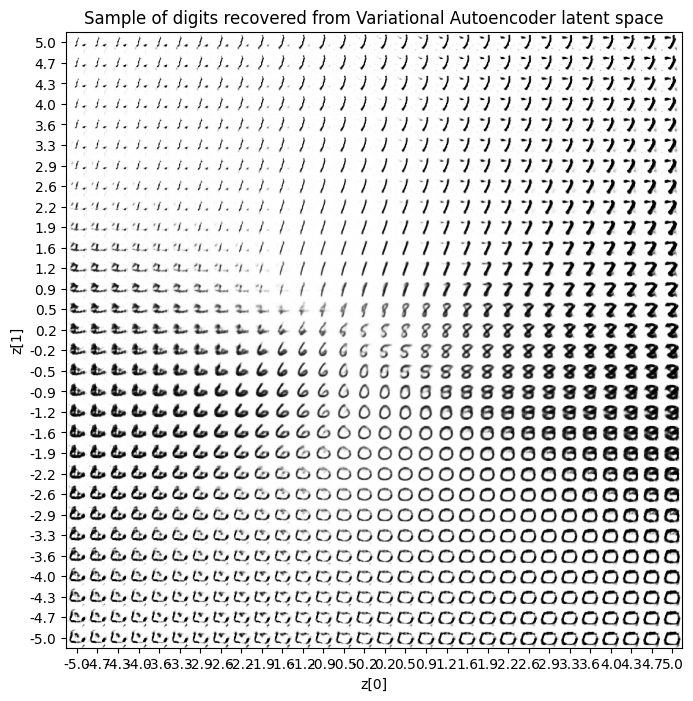

In [18]:
def plot_results(model, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        vae.eval()
        with torch.no_grad():
            encoded_img  = model.encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = model.decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

plot_results(vae, test_dataset, rx=(-5, 5), ry=(-5, 5), model_name="Variational Autoencoder")

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table